In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['accuracy'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
        
def preprocessing(PPG_data):
    index = 0
    x = list(range(0,len(PPG_data[0])))
    for PPG in PPG_data:
        poly = np.polyfit(x, PPG, deg=50)
        polied = np.polyval(poly, x)
        detrended = PPG - polied
        PPG_data[index] = detrended
        index += 1
        
        
    return PPG_data
    
def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    result = []
    peaks = []
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
for i in range(22):
    dir_list.append(dir_list_[i])
    
#### pop unavailable data
dir_list.pop(5)
    
print(dir_list)
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])
Valence_data = []
Arousal_data = []
PPG_data = []

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
        PPG_data.append(dataP)
        Valence_data.append(Valence)
        Arousal_data.append(Arousal)
    file_num += 1
    
PPG_shape = np.array(PPG_data)
PPG_shape.shape

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat']


(840, 7680)

## Load & Preprocess PPG data

In [4]:
PPG_data = df_PPG['ppg']

preprocessed = preprocessing(PPG_data)

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


## Normalize PPG data

In [5]:
# Concatenate PPG data of each person to use min-max normalization method 
i = 1
new_PPG = []
tmp_PPG = np.empty(0)
for PPG in preprocessed:
    if i % 40 != 0:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])Untitled2
    else:
        tmp_PPG = np.concatenate([tmp_PPG, PPG])
        new_PPG.append(tmp_PPG)
        tmp_PPG = np.empty(0)
    i += 1
    
    
# Normalize personal PPG data and Split into per video
new_PPG = np.array(new_PPG)
new_PPG.shape[0]
new_PPG = new_PPG.reshape(new_PPG.shape[0],new_PPG.shape[1],1)

normalized = []

for PPG in new_PPG:
    # Normalized personal PPG
    scaler = MinMaxScaler()
    norm = scaler.fit_transform(PPG) * 1000
    
    # Split into per video
    for i in range(40):
        norm_video = norm[i*7680 : i*7680+7680]
        normalized.append(norm_video)

normalized = np.array(normalized)
normalized.shape

(840, 7680, 1)

In [6]:
import neurokit2.ppg.ppg_findpeaks as findpeaks

{'PPG_Peaks': array([ 110,  235,  362,  483,  601,  721,  837,  953, 1075, 1190, 1311,
       1430, 1534, 2008, 2094, 2199, 2313, 2432, 2818, 2951, 3067, 3191,
       3315, 3436, 3550, 3665, 3783, 3894, 4005, 4121, 4241, 4358, 4484,
       4604, 4723, 4846, 4962, 5082, 5203, 5318, 5442, 5811, 5929, 6044,
       6167, 6558, 6681, 6779, 6895, 7004, 7110, 7218, 7321, 7550])}


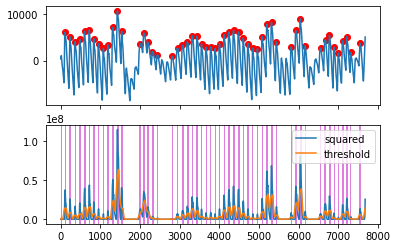

In [7]:
result = findpeaks(preprocessed[0], sampling_rate=128, show=True)
print(result)

In [8]:
print(result, len(preprocessed[0]))

{'PPG_Peaks': array([ 110,  235,  362,  483,  601,  721,  837,  953, 1075, 1190, 1311,
       1430, 1534, 2008, 2094, 2199, 2313, 2432, 2818, 2951, 3067, 3191,
       3315, 3436, 3550, 3665, 3783, 3894, 4005, 4121, 4241, 4358, 4484,
       4604, 4723, 4846, 4962, 5082, 5203, 5318, 5442, 5811, 5929, 6044,
       6167, 6558, 6681, 6779, 6895, 7004, 7110, 7218, 7321, 7550])} 7680


In [10]:
segmented = []
index = 0
cal= 0

for i in range(0,21):
    for PPG in normalized:

        tmp = []
        result = findpeaks(PPG, sampling_rate=128)
        a = result['PPG_Peaks']
        for idx in a:
            a = idx
            if a > 70:
                seg = PPG[a-70:a+70]
                times = list(range(0,len(seg)))
            else:
                seg = PPG[0:a+70]
                times = list(range(0,len(seg)))
            if len(seg) == 140:
                cal+=1
                tmp.append(seg)

        segmented.append(tmp)
        index += 1

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:


normalized = []
index = 0
idx = 0
tmp = []
valence_data = []
arousal_data = []
for PPG in segmented:
    for segment in PPG:
        tmp.append(segment)
    if index == 39:
        tmp = np.array(tmp)
        print(tmp.shape)
        scaler = MinMaxScaler(feature_range=(0,1))
        norm = scaler.fit_transform(tmp) * 1000
        for i in norm:
            normalized.append(i)
            # valence_data.append(Valence_data[idx])
            # arousal_data.append(Arousal_data[idx])
        index = 0
        tmp = []
    index+=1
    idx += 1

In [ ]:
print(normalized[0])
print(len(normalized[0]))

In [ ]:
print(len(normalized))

In [ ]:
for i in range(0,22):
    plt.figure(figsize=(70,35))
    times = list(range(0,140))
    
    for PPG in normalized[i*40:(i*40)+40]:
        plt.plot(times, PPG)
    
    person_num = i
    plt.savefig(f'segmented_data1seconds/normalized/{person_num}.png', bbox_inches='tight')
    plt.show()
    plt.close()
    print(i,"done")

In [ ]:
train_x = normalized
train_valence = valence_data
train_arousal = arousal_data
print(len(train_valence))

In [ ]:
x_train_data = np.array(train_x).astype(np.float64)
y_train_data = np.array(train_valence).astype(np.float64)
print(x_train_data.shape, y_train_data.shape)

# normalize train data
# nsamples, nx, ny = x_train_data.shape
# train_dataset = x_train_data.reshape((nsamples,nx*ny))
# scaler = MinMaxScaler(feat
# transform(x_train_data)

X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1], 1))
Y_train = y_train_data.reshape((y_train_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")

In [ ]:
# Set Hyperparameters of the model
learning_rate = 0.0001
epochs = 50
batch_size=128

In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
import random
from tensorflow.keras.initializers import glorot_uniform
seed = 12345
np.random.seed(seed)
random.seed(seed)

def create_model():
    model = Sequential()
    model.add(Conv1D(16, 2, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())       
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed = seed)))
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.0005), metrics = ['accuracy'])
    #print(model.summary())

    return model

In [ ]:
model = create_model()

In [ ]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  shuffle=True,
                  verbose=1)

In [ ]:
plt_performance(history,path='./plot_performance',filename='1DCNN_performance6')